# Clone my driving behavior

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, Lambda, Cropping2D, Activation, BatchNormalization
from keras.optimizers import Adam
import keras.backend as K
from livelossplot import PlotLossesKeras
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import cloning.image_generator as ig
from cloning.visualizations import plot_layers

/home/mariosk/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
user = !whoami
user = user[0]

In [3]:
PROJECT_DIR = '/home/ubuntu/cloning' if user == 'ubuntu' else '/home/mariosk/Desktop/autonomous_driving/CarND-Behavioral-Cloning-P3'
IMAGE_SHAPE = (160, 320, 3)

IMAGE_DIRECTORIES = [
    'first_drives', 
    '3_forward_rounds', 
    '3_backward_rounds',
    'edges_forward',
    'edges_backward',
    'edges_smooth',
    '2_rounds_for_testing',
    '3_more_fw_rounds',
    '3_more_bw_rounds',
    ('driving_on_the_edge_fw_left', 0.15),
    ('driving_on_the_edge_fw_right', -0.15),
    '6_fw',
    '6_bw',
    '3_bw_hard',
    '3_fw_hard',
    '1_round_fw_hard_level'
]

LOAD_ALL_IMAGES_IN_MEMORY = False
BATCH_SIZE = 32
TRAIN_SET_SIZE = ig.load_image_registries(PROJECT_DIR, IMAGE_DIRECTORIES).shape[0]

## Load images and measurements

In [4]:
if LOAD_ALL_IMAGES_IN_MEMORY:
    all_data = ig.load_all_images(PROJECT_DIR, IMAGE_DIRECTORIES)
    train_generator = ig.image_generator_from_dataset(*all_data, batch_size=BATCH_SIZE, augment=True)
else:
    train_generator = ig.image_generator_from_files(PROJECT_DIR, IMAGE_DIRECTORIES, batch_size=BATCH_SIZE, augment=True)
    
print(f'Number of train samples: {TRAIN_SET_SIZE}')

Number of train samples: 55169


In [5]:
%%time
valid_images, valid_meas = ig.load_all_images(PROJECT_DIR, ['validation_rounds', 'validation_rounds_bw'])
print(f'Number of valid samples: {valid_meas.shape[0]}')

Number of valid samples: 4234
CPU times: user 10.4 s, sys: 1.21 s, total: 11.6 s
Wall time: 12.3 s


In [6]:
%%time
test_images, test_meas = ig.load_all_images(PROJECT_DIR, ['test_rounds', 'test_rounds_bw'])
print(f'Number of test samples: {test_meas.shape[0]}')

Number of test samples: 5463
CPU times: user 13.6 s, sys: 1.2 s, total: 14.8 s
Wall time: 15.7 s


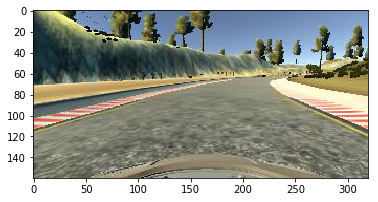

In [7]:
plt.imshow(next(train_generator)[0][0])
plt.show()

In [5]:
model = Sequential([
    Cropping2D(cropping=((70, 25), (0, 0)), input_shape=IMAGE_SHAPE, name='crop'),
    Lambda(lambda image: image / 255.0 - 0.5, name='scale'),
    
    Conv2D(24, (5, 5), strides=(2, 2)),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(36, (5, 5), strides=(2, 2)),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(48, (5, 5), strides=(2, 2)),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    
    Flatten(),
    
    Dense(100),
    BatchNormalization(),
    Activation('relu'),
    
    Dense(50),
    BatchNormalization(),
    Activation('relu'),
    
    Dense(10),
    BatchNormalization(),
    Activation('relu'),
    
    Dense(1, activation='linear')
])

model.compile(loss='mse', optimizer=Adam(lr=0.0005))

In [7]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

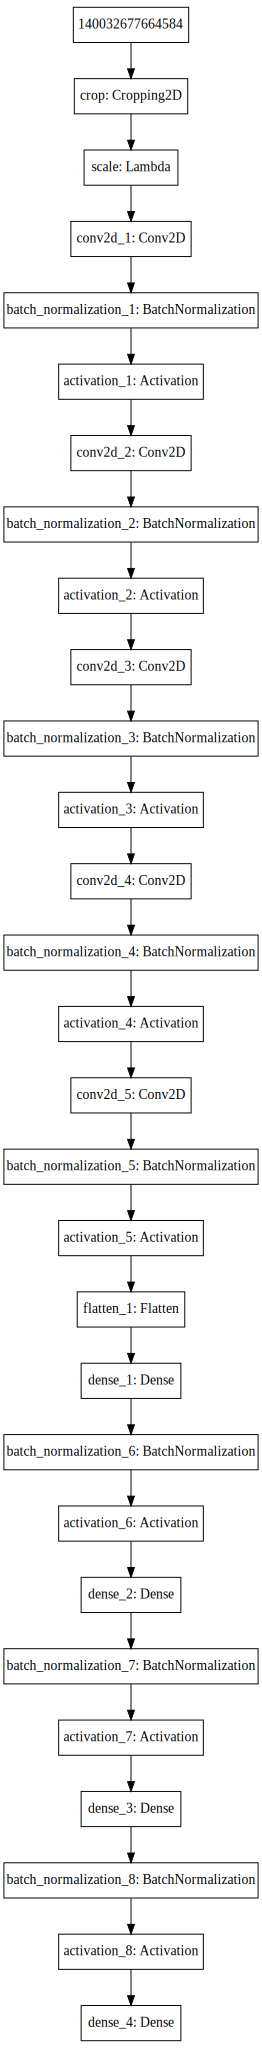

In [6]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Train model

In [10]:
%%time
steps_per_epoch = int(TRAIN_SET_SIZE / BATCH_SIZE)
validation_steps = int(valid_meas.shape[0] / BATCH_SIZE)

model.fit_generator(
    train_generator,
    validation_data=[valid_images, valid_meas],
    epochs=1,
    steps_per_epoch=steps_per_epoch,
    max_queue_size=40,
    use_multiprocessing=True,
    workers=8
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1724/1724 [==============================] - 58s 33ms/step - loss: 0.0529 - val_loss: 0.0151
CPU times: user 1min 26s, sys: 8.42 s, total: 1min 34s
Wall time: 59.3 s


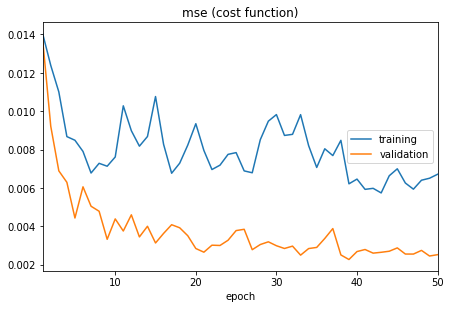

mse (cost function):
training   (min:    0.006, max:    0.014, cur:    0.007)
validation (min:    0.002, max:    0.014, cur:    0.003)
CPU times: user 1h 5min 45s, sys: 6min, total: 1h 11min 45s
Wall time: 42min 42s


In [11]:
%%time
model.fit_generator(
    train_generator,
    validation_data=[valid_images, valid_meas],
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    callbacks=[PlotLossesKeras()],
    max_queue_size=40,
    use_multiprocessing=True,
    workers=8
)

In [12]:
test_mse = model.evaluate(test_images, test_meas)
test_rmse = np.sqrt(test_mse)
print(f'Test set MSE: {test_mse:.3f}')
print(f'Test set RMSE: {test_rmse:.3f}')

5463/5463 [==============================] - 2s 443us/step
Test set MSE: 0.002
Test set RMSE: 0.049


In [13]:
model.save('./models/model_nvidia_avoiding_edges_with_fixed_angle_hard_level.h5')

In [14]:
!./upload_models_to_s3.sh

upload: models/model_nvidia_avoiding_edges_with_fixed_angle_hard_level.h5 to s3://behavioral-cloning-models/model_nvidia_avoiding_edges_with_fixed_angle_hard_level.h5


## Compare original and predicted angle distributions

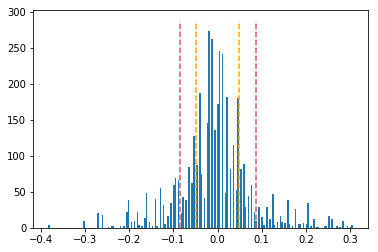

In [15]:
plt.hist(valid_meas, bins=200)
ylim = plt.ylim()
test_std = test_meas.std()
test_mean = test_meas.mean()

plt.vlines(test_rmse + test_mean, *ylim, color='orange', linestyle='--')
plt.vlines(-test_rmse + test_mean, *ylim, color='orange', linestyle='--')
plt.vlines(test_std + test_mean, *ylim, color='indianred', linestyle='--')
plt.vlines(-test_std + test_mean, *ylim, color='indianred', linestyle='--')
plt.show()

In [16]:
%%time
predictions = model.predict(valid_images)

CPU times: user 2.21 s, sys: 104 ms, total: 2.31 s
Wall time: 2.06 s


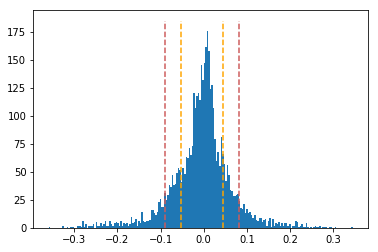

In [17]:
plt.hist(predictions, bins=200)
ylim = plt.ylim()
predictions_mean = predictions.mean()

plt.vlines(test_rmse + predictions_mean, *ylim, color='orange', linestyle='--')
plt.vlines(-test_rmse + predictions_mean, *ylim, color='orange', linestyle='--')
plt.vlines(test_std + predictions_mean, *ylim, color='indianred', linestyle='--')
plt.vlines(-test_std + predictions_mean, *ylim, color='indianred', linestyle='--')

plt.show()

## Visualize output of convolution layers

In [18]:
inp = model.input
relevant_layers = [layer for layer in model.layers if 'conv2d' in layer.name]
layer_names = [layer.name for layer in relevant_layers]
outputs = [layer.output for layer in relevant_layers]
evaluation_functions = K.function([inp, K.learning_phase()], outputs)

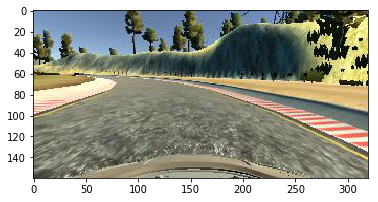

In [19]:
test_image = test_images[0]
plt.imshow(test_image)
plt.show()

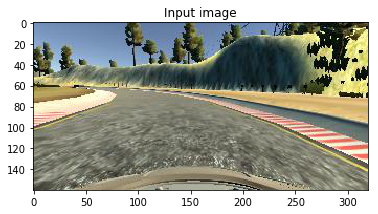

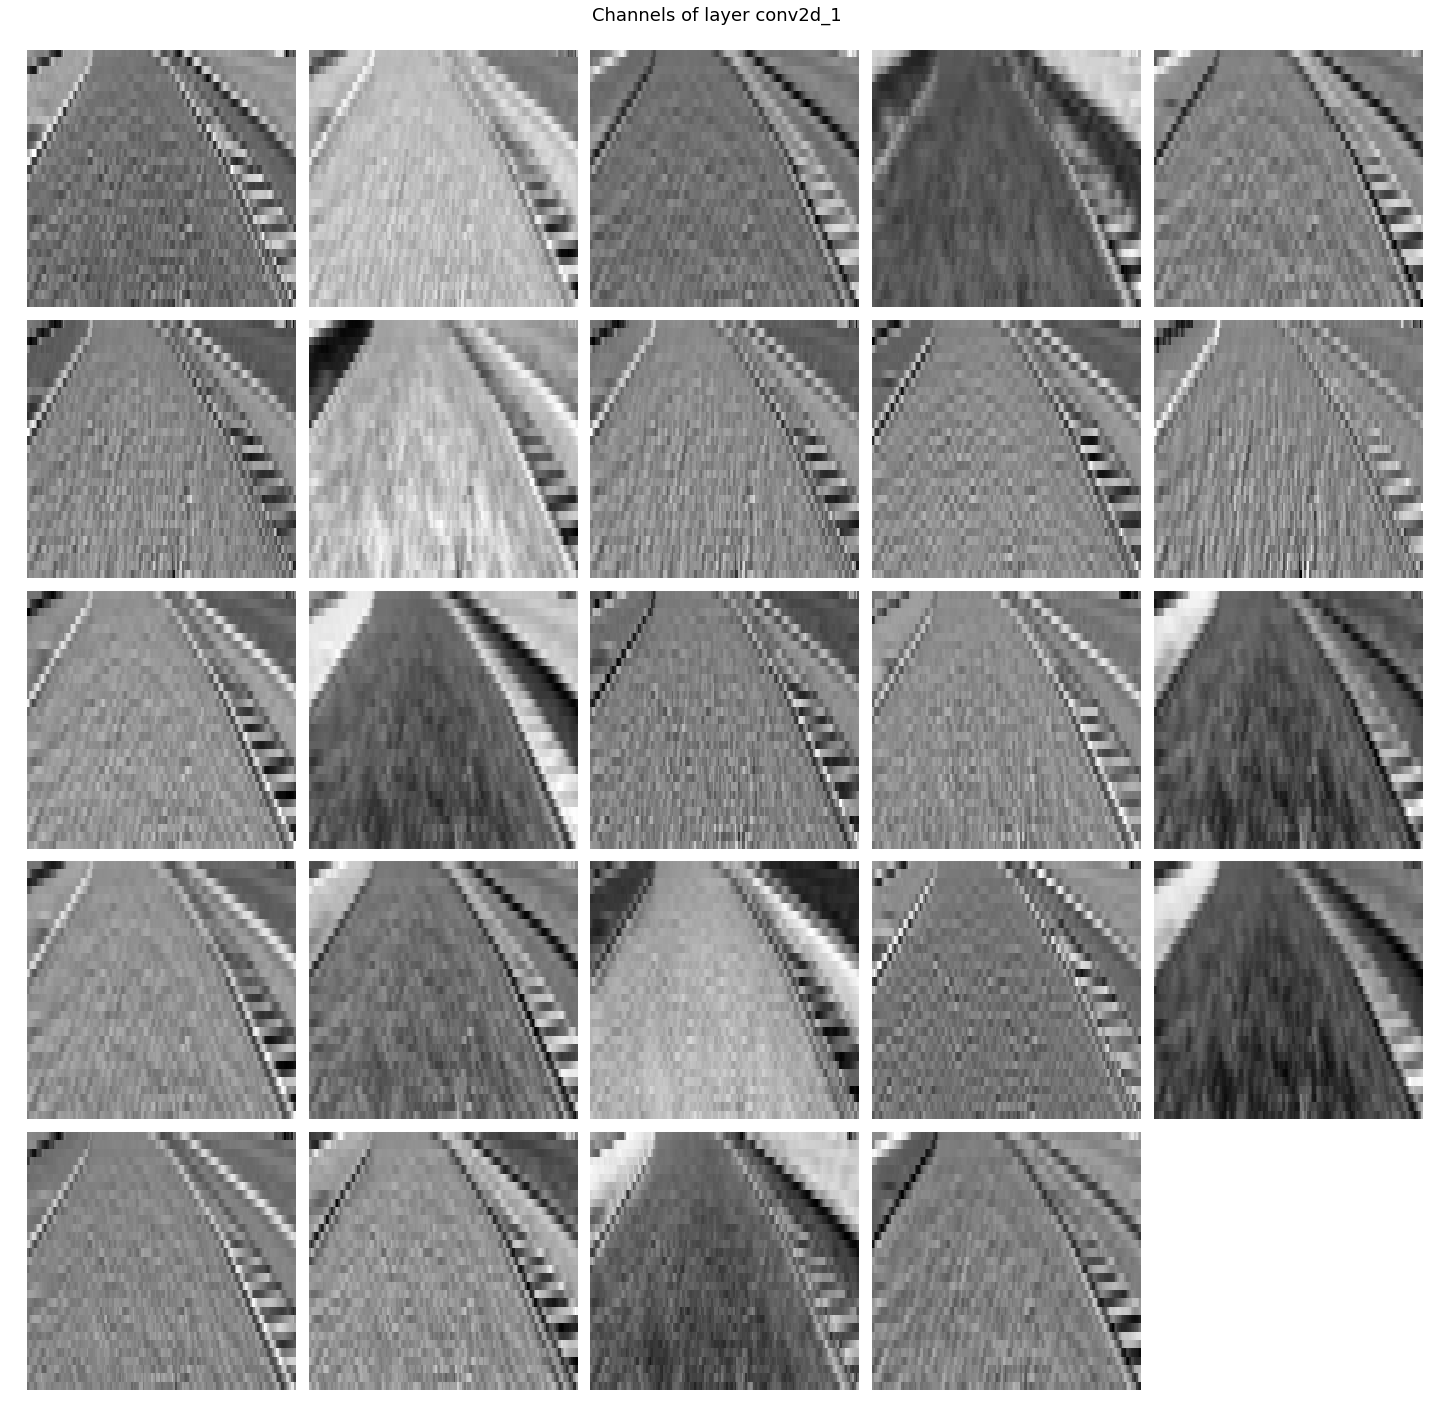

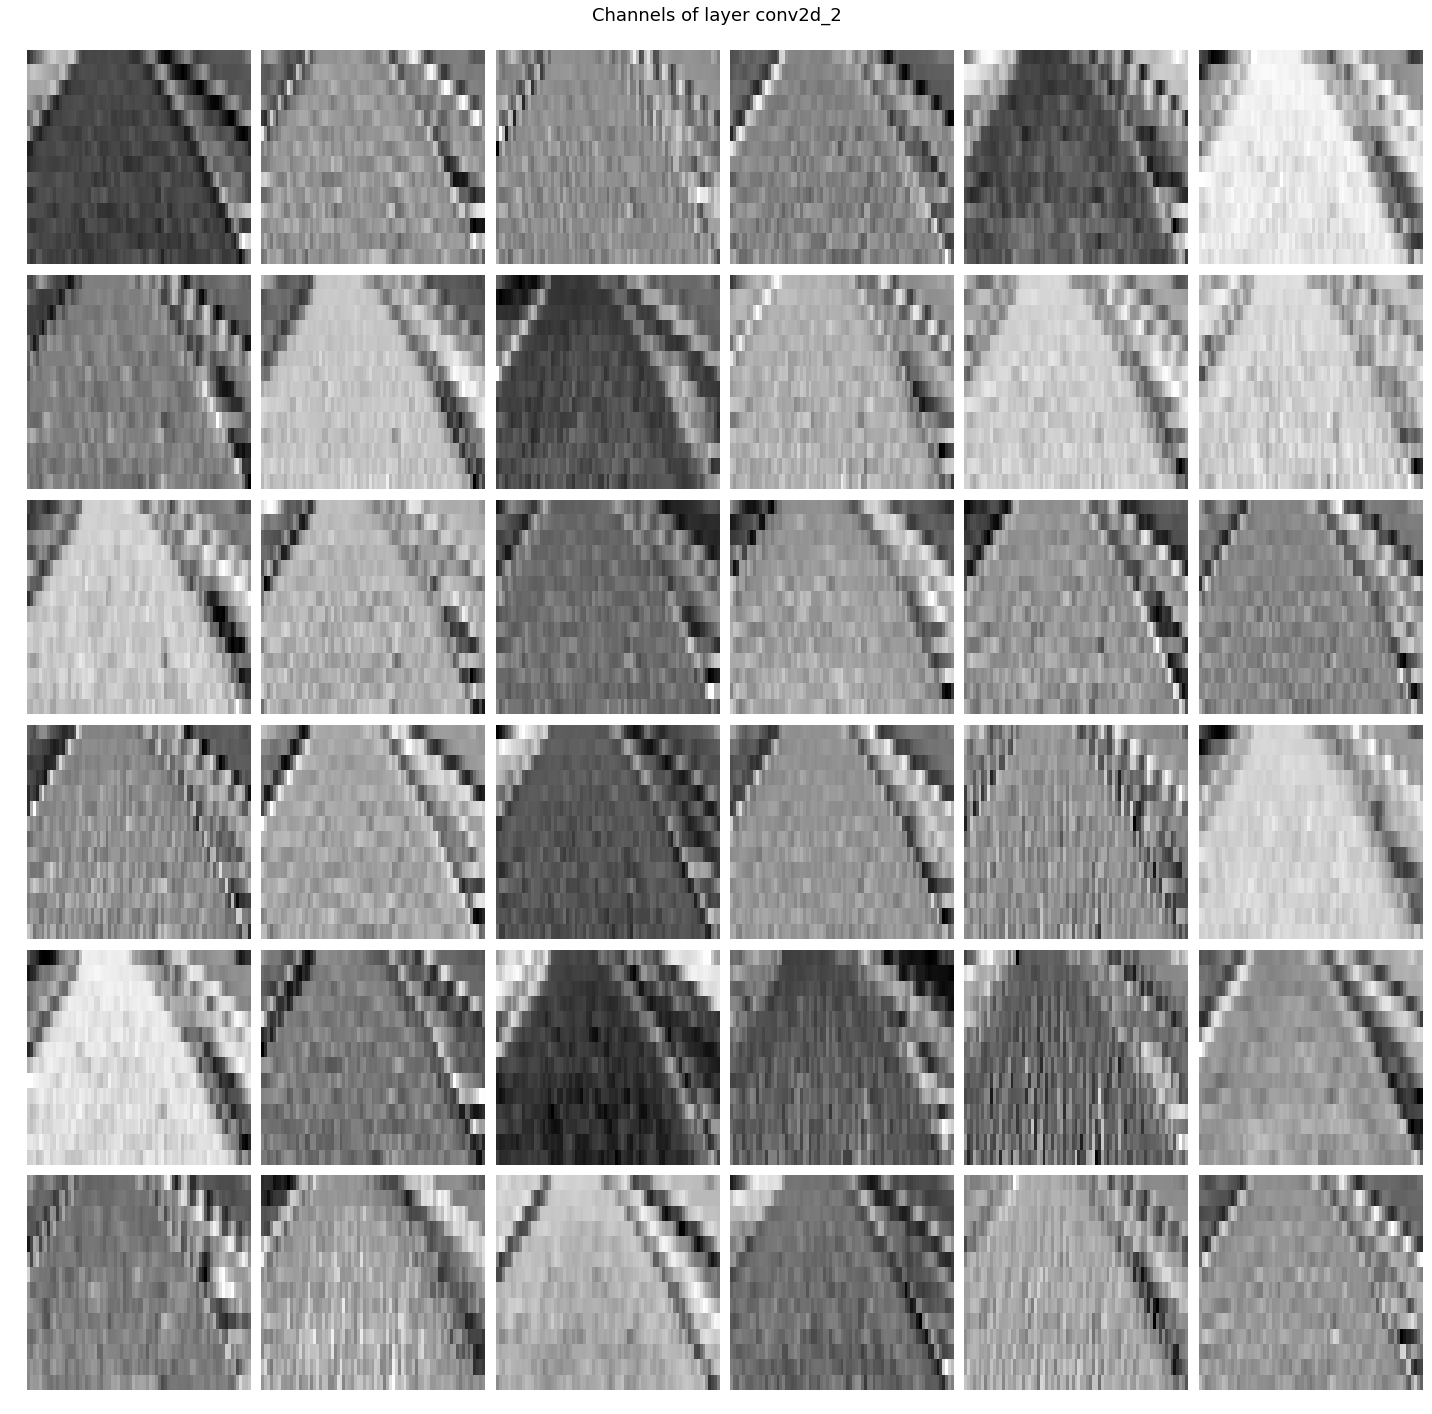

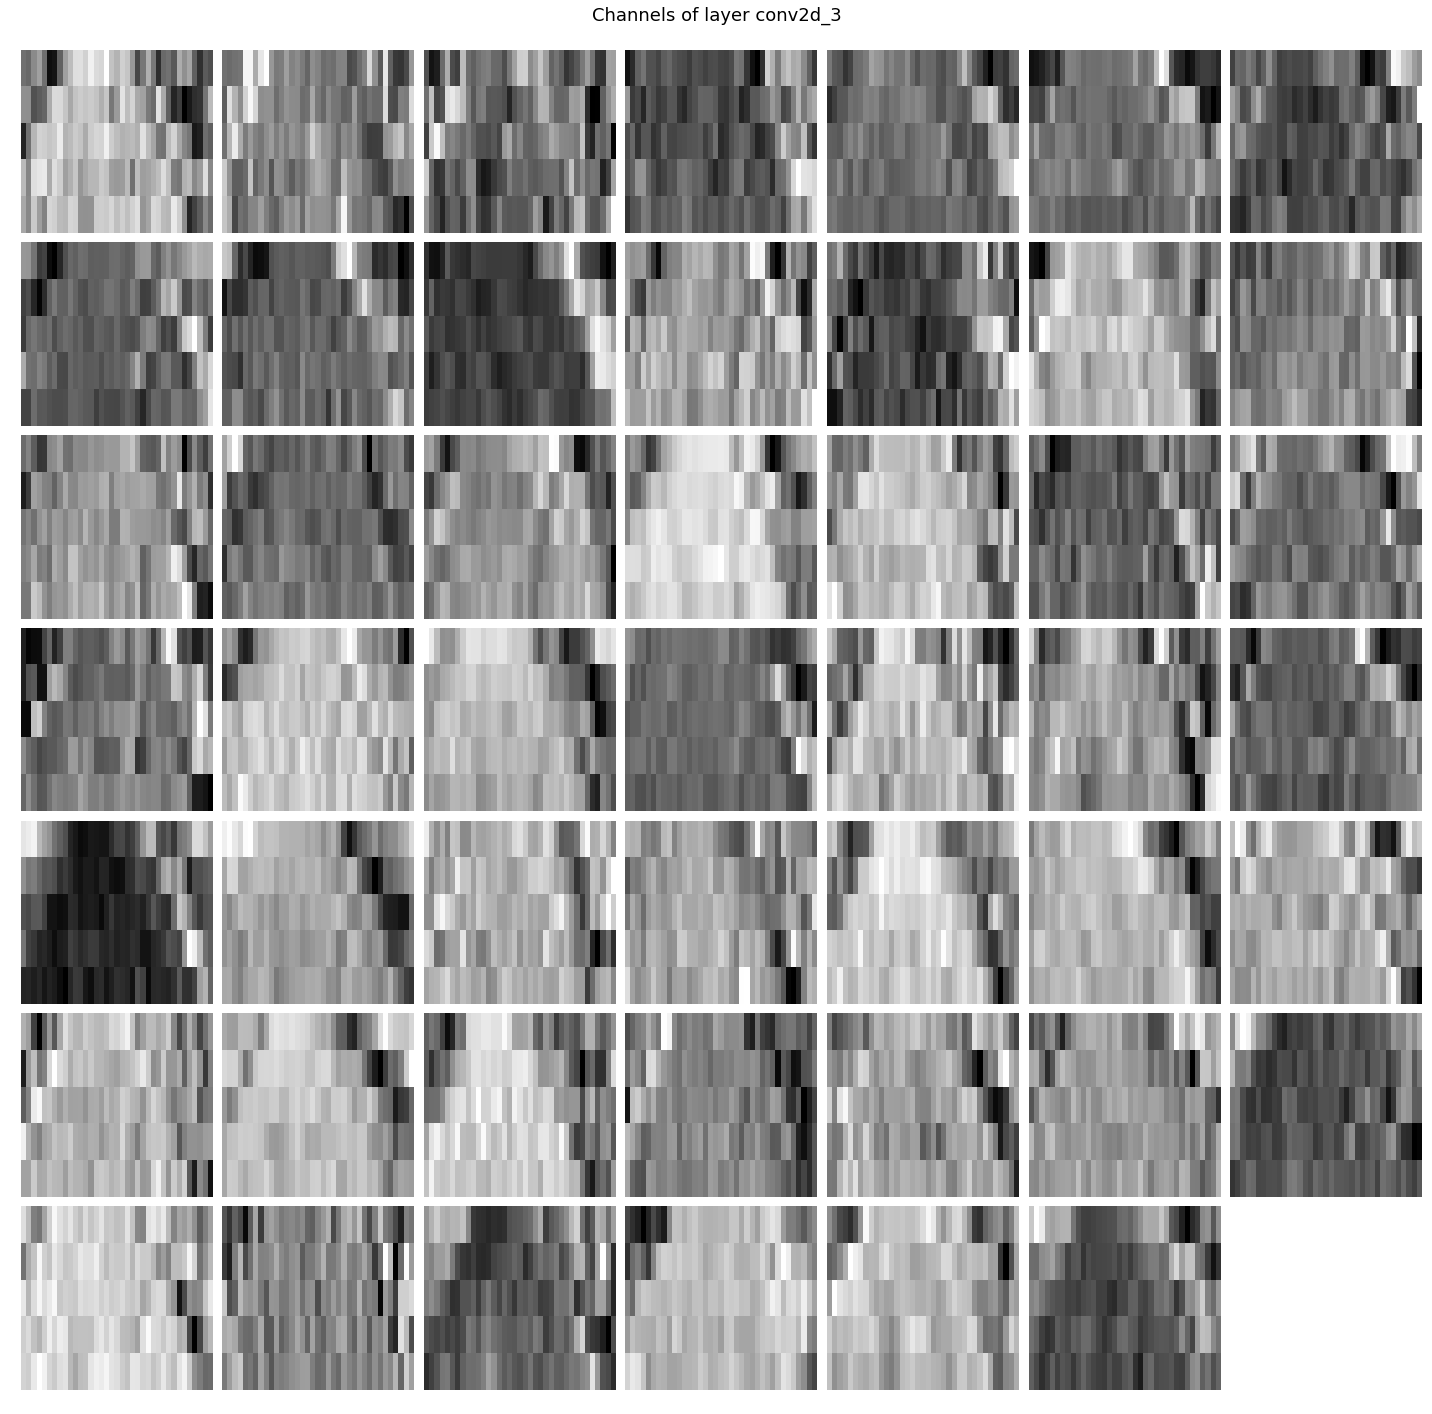

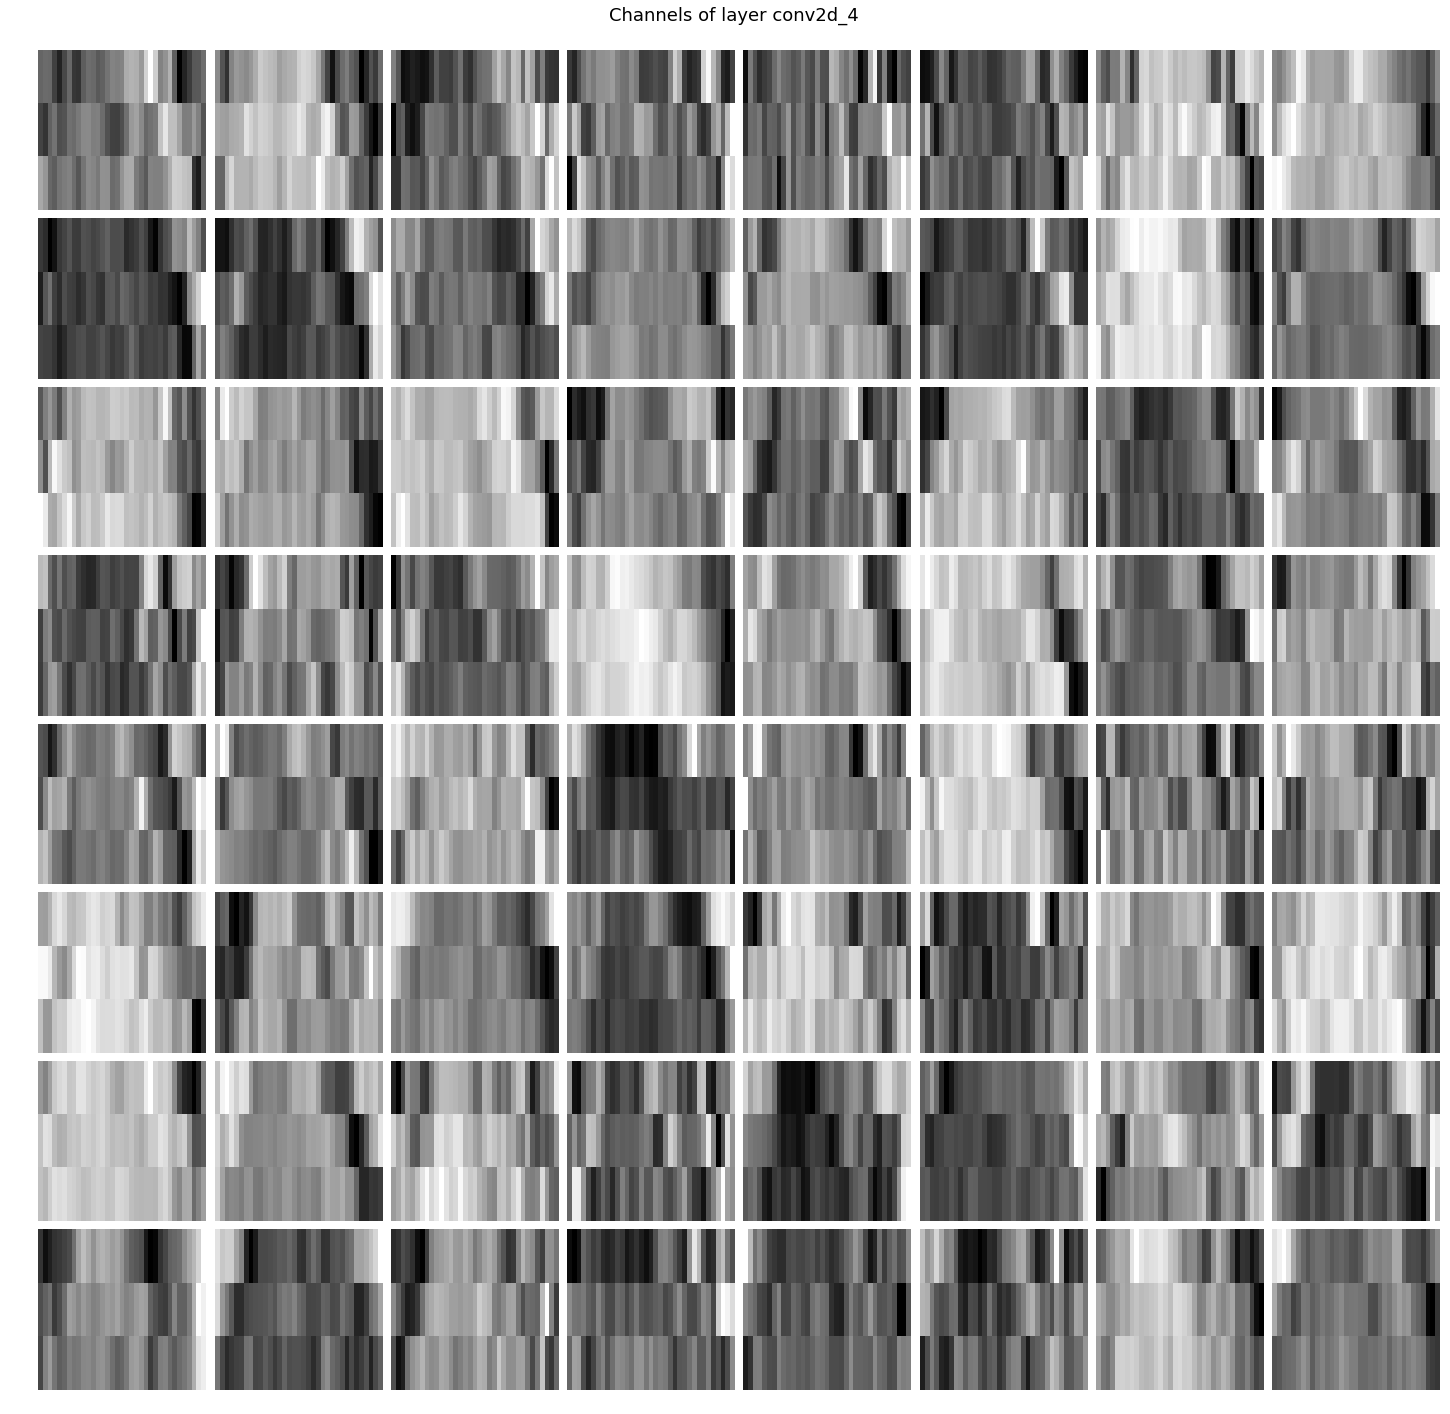

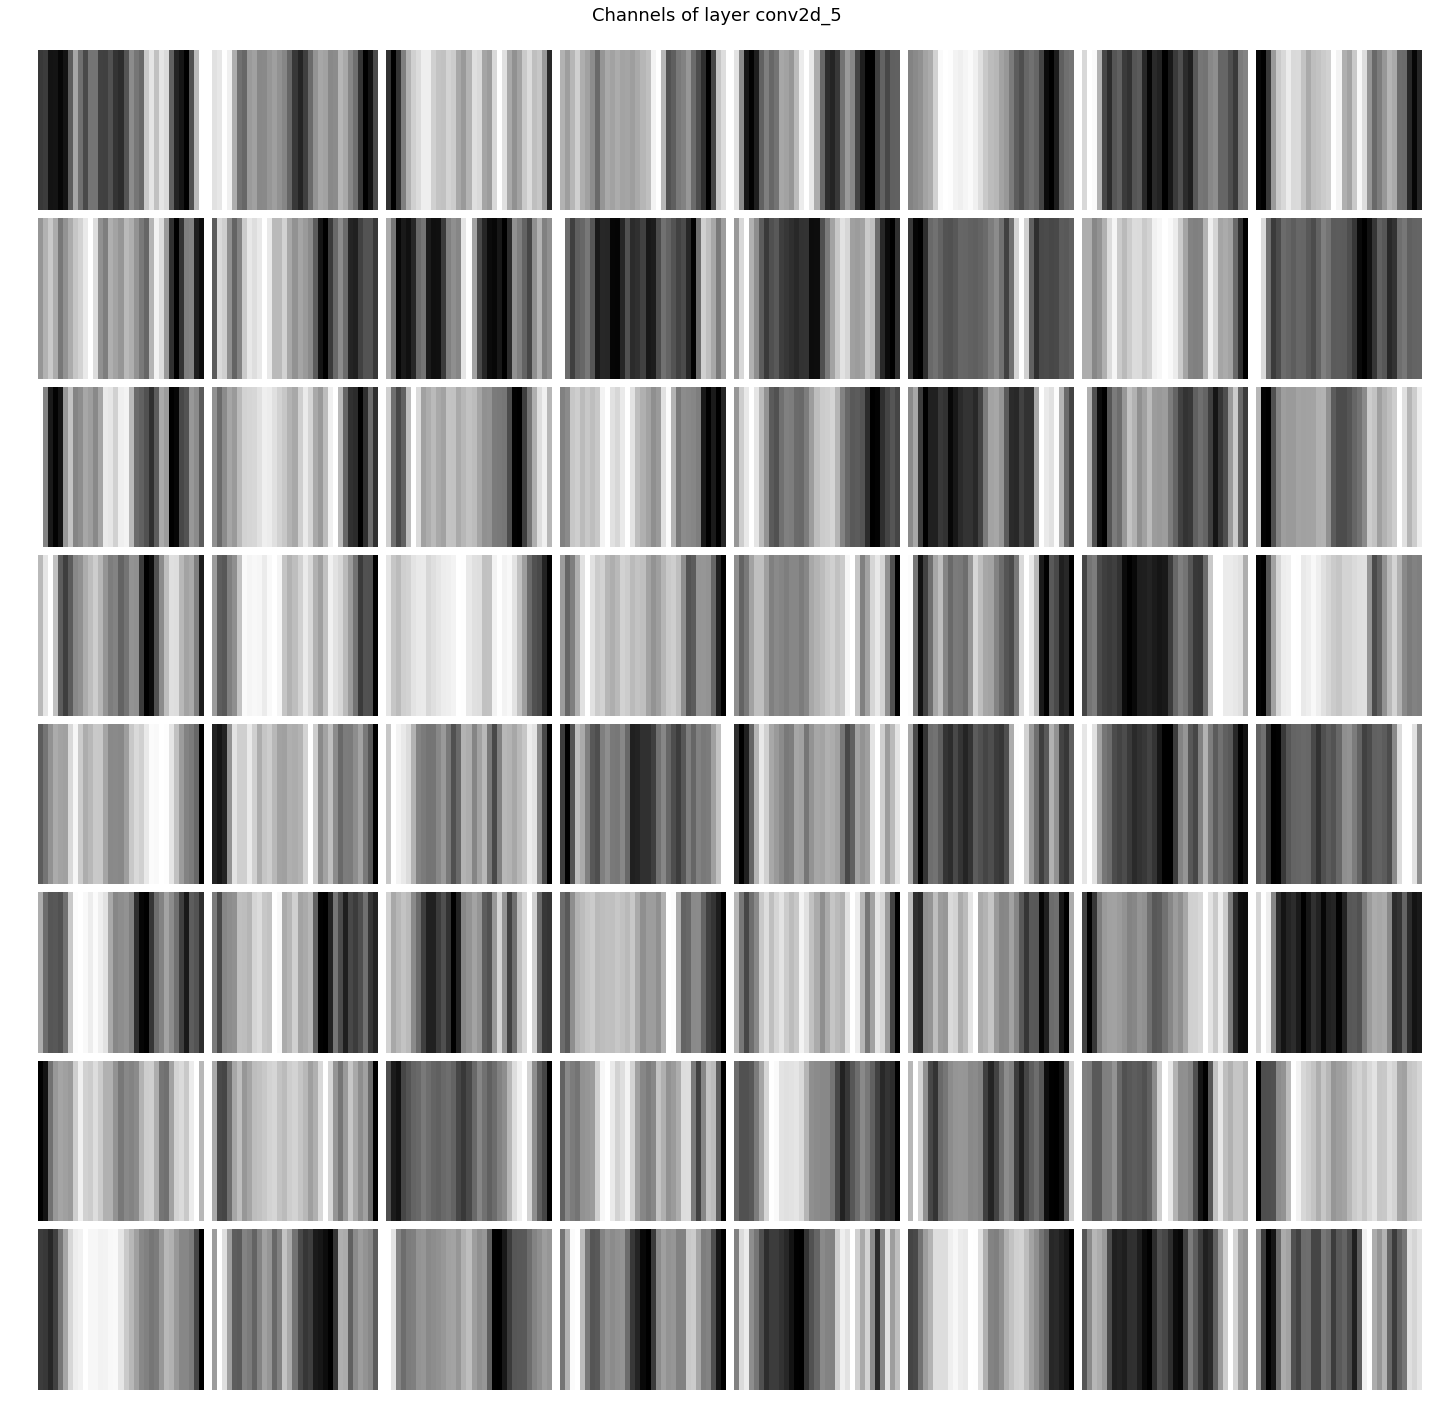

In [20]:
plot_layers(test_image, evaluation_functions, layer_names)